# Student Performance Prediction using Deep Learning

**Course:** U21ADP05 – Exploratory Data Analysis and Visualization   
**Student:** Galvin A G
**Submission Date:** 20/10/2025

---
This notebook performs EDA and builds a Deep Learning model (MLP) on a student performance dataset.

**Data options:**
- Place the Kaggle file `student-mat.csv` next to this notebook, or update `DATA_PATH` below.
- If the file is *not* found, the notebook will auto-generate a **synthetic** dataset with a similar schema so you can run all steps end-to-end.


In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Matplotlib defaults
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['axes.grid'] = True

DATA_PATH = './student-por.csv'  # Update if needed


In [2]:
# Load real dataset if available; else synthesize a similar one
rng = np.random.default_rng(42)
if os.path.exists(DATA_PATH):
    df = pd.read_csv(DATA_PATH)
    source_info = 'Loaded real dataset from student-mat.csv'
else:
    # Synthetic generator approximating the student performance schema
    n = 700
    gender = rng.choice(['F','M'], size=n)
    age = rng.integers(15, 22, size=n)
    studytime = rng.integers(1, 5, size=n)  # 1..4
    failures = rng.choice([0,0,0,1,1,2,3], size=n)
    absences = np.clip(rng.normal(6, 5, size=n).round().astype(int), 0, 40)
    G1 = np.clip((rng.normal(11, 3, size=n) + 0.6*studytime - 0.7*failures - 0.05*absences), 0, 20)
    G2 = np.clip((G1 + rng.normal(0.8, 2.0, size=n)), 0, 20)
    G3 = np.clip((0.2*G1 + 0.6*G2 + 0.6*studytime - 0.8*failures - 0.05*absences + rng.normal(0,2,size=n)), 0, 20)
    school = rng.choice(['GP','MS'], size=n)
    address = rng.choice(['U','R'], size=n)
    internet = rng.choice(['yes','no'], size=n, p=[0.75,0.25])
    df = pd.DataFrame({
        'sex': gender,
        'age': age,
        'studytime': studytime,
        'failures': failures,
        'absences': absences,
        'G1': G1.round().astype(int),
        'G2': G2.round().astype(int),
        'G3': G3.round().astype(int),
        'school': school,
        'address': address,
        'internet': internet
    })
    source_info = 'Synthetic dataset generated (use real CSV for final submission if available)'
df.head(), source_info

(  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
 0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
 1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
 2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
 3     GP   F   15       U     GT3       T     4     2   health  services  ...   
 4     GP   F   16       U     GT3       T     3     3    other     other  ...   
 
   famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
 0      4        3      4     1     1      3        4   0  11  11  
 1      5        3      3     1     1      3        2   9  11  11  
 2      4        3      2     2     3      3        6  12  13  12  
 3      3        2      2     1     1      5        0  14  14  14  
 4      4        3      2     1     2      5        0  11  13  13  
 
 [5 rows x 33 columns],
 'Loaded real dataset from student-mat.csv')

##  Basic Info & Cleaning

In [3]:
print(source_info)
print('\nShape:', df.shape)
print('\nColumns:', list(df.columns))
print('\nMissing values per column:\n', df.isna().sum())

# Basic cleaning: drop full-NA rows (rare), handle duplicates
df = df.dropna(how='all').drop_duplicates()
print('\nAfter cleaning -> Shape:', df.shape)

Loaded real dataset from student-mat.csv

Shape: (649, 33)

Columns: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']

Missing values per column:
 school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

After cleaning -> Shape: (649, 3

##  Visualizations
Using **matplotlib** only (as required for consistency).

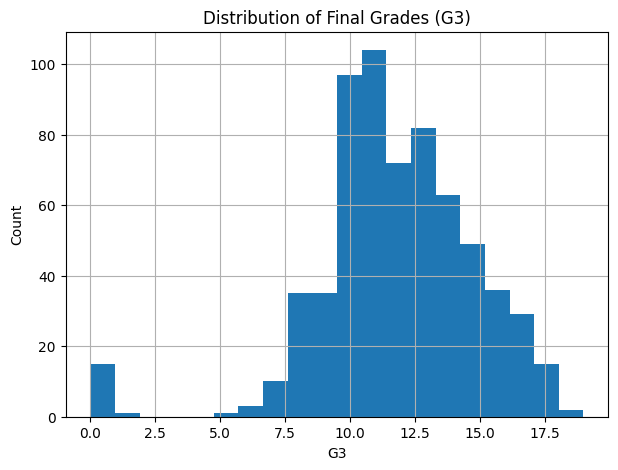

In [4]:
# 1) Histogram of Final Grades (G3)
plt.figure()
plt.hist(df['G3'], bins=20)
plt.title('Distribution of Final Grades (G3)')
plt.xlabel('G3'); plt.ylabel('Count')
plt.show()

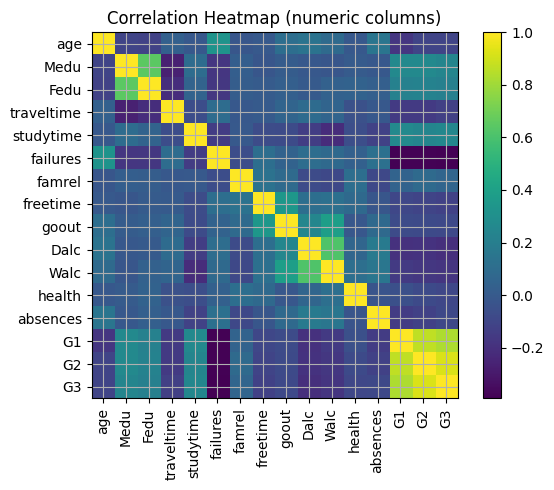

In [5]:
# 2) Correlation Heatmap using matplotlib
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()
plt.figure()
im = plt.imshow(corr, interpolation='nearest')
plt.title('Correlation Heatmap (numeric columns)')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.tight_layout()
plt.show()

/tmp/ipython-input-3967119235.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=sorted(df['studytime'].unique()))


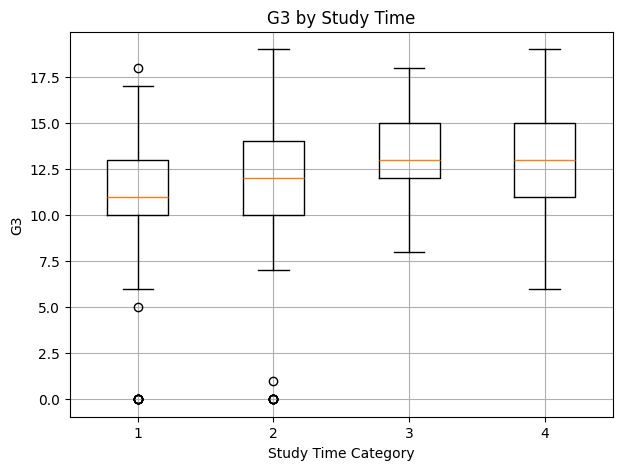

In [6]:
# 3) Boxplot: Studytime vs G3
plt.figure()
groups = [df[df['studytime']==i]['G3'].values for i in sorted(df['studytime'].unique())]
plt.boxplot(groups, labels=sorted(df['studytime'].unique()))
plt.title('G3 by Study Time')
plt.xlabel('Study Time Category'); plt.ylabel('G3')
plt.show()

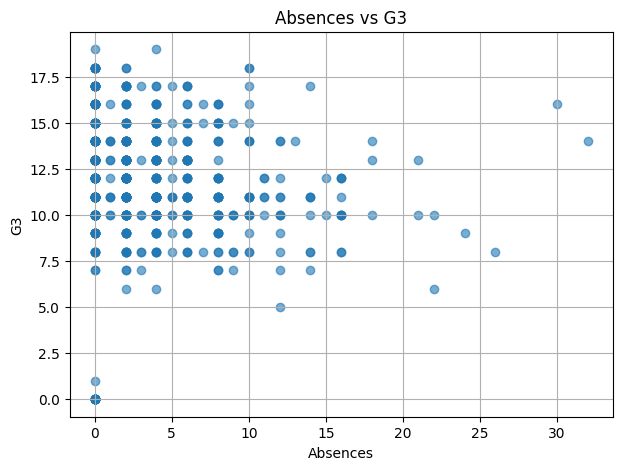

In [7]:
# 4) Scatter: Absences vs G3
plt.figure()
plt.scatter(df['absences'], df['G3'], alpha=0.6)
plt.title('Absences vs G3')
plt.xlabel('Absences'); plt.ylabel('G3')
plt.show()

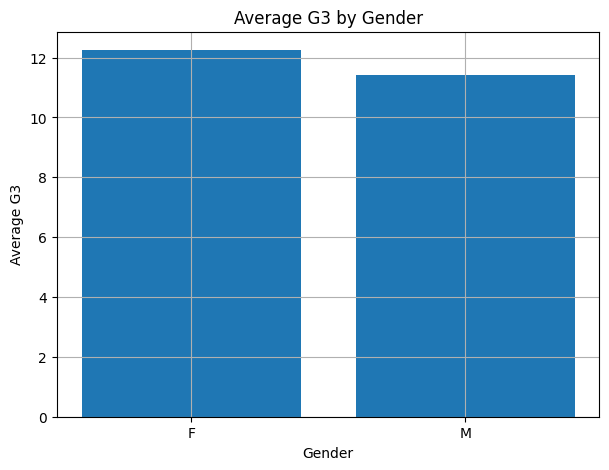

In [8]:
# 5) Bar plot: Gender-wise Average Grades
gender_mean = df.groupby('sex')['G3'].mean().reindex(['F','M'])
plt.figure()
plt.bar(gender_mean.index.astype(str), gender_mean.values)
plt.title('Average G3 by Gender')
plt.xlabel('Gender'); plt.ylabel('Average G3')
plt.show()

##  Preprocessing & Split
- Encode categoricals
- Scale numeric features
- Train/Val/Test split

In [9]:
df_proc = df.copy()
cat_cols = df_proc.select_dtypes(include=['object']).columns
encoders = {}
for c in cat_cols:
    enc = LabelEncoder()
    df_proc[c] = enc.fit_transform(df_proc[c].astype(str))
    encoders[c] = enc

# Classification target: pass/fail threshold (>=10 is pass)
df_proc['target'] = (df_proc['G3'] >= 10).astype(int)

X = df_proc.drop(columns=['target'])
y = df_proc['target']

# Keep G3 as feature? Typically no; drop it to avoid leakage
if 'G3' in X.columns:
    X = X.drop(columns=['G3'])

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

X_train.shape, X_val.shape, X_test.shape

((454, 32), (97, 32), (98, 32))

##  MLP Classifier
**Architecture:** Dense(64) → Dropout(0.2) → Dense(32) → Dense(1, sigmoid)


In [10]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_s.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist = model.fit(X_train_s, y_train, validation_data=(X_val_s, y_val), epochs=100, batch_size=32, callbacks=[es], verbose=0)
test_loss, test_acc = model.evaluate(X_test_s, y_test, verbose=0)
print(f'Test Accuracy: {test_acc:.4f}')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8878


## Evaluation Visualizations

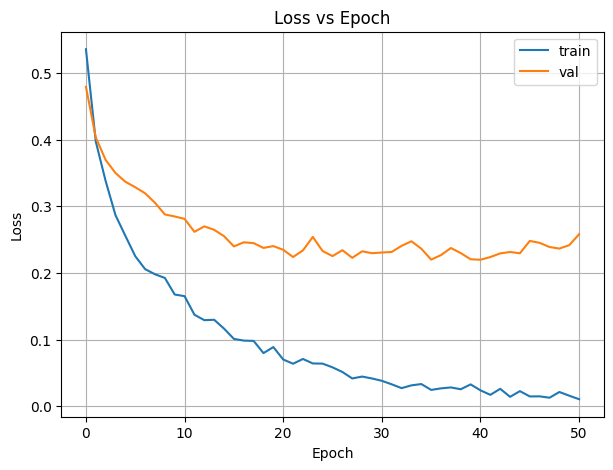

In [11]:
# 1) Loss vs Epoch
plt.figure()
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()
plt.show()

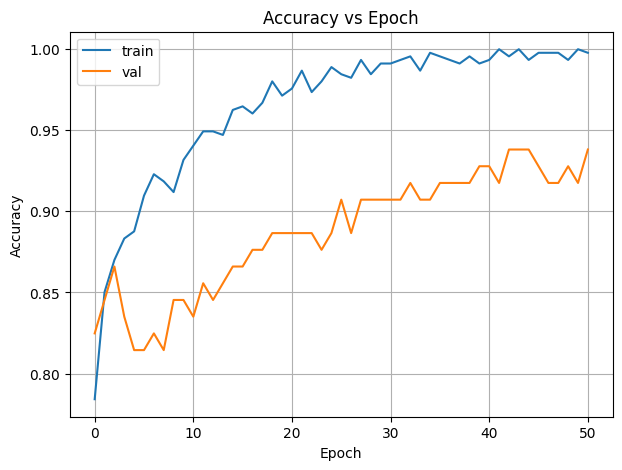

In [12]:
# 2) Accuracy vs Epoch
plt.figure()
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# Predictions
y_prob = model.predict(X_test_s).ravel()
y_pred = (y_prob >= 0.5).astype(int)
print(classification_report(y_test, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
              precision    recall  f1-score   support

           0       0.67      0.53      0.59        15
           1       0.92      0.95      0.93        83

    accuracy                           0.89        98
   macro avg       0.79      0.74      0.76        98
weighted avg       0.88      0.89      0.88        98



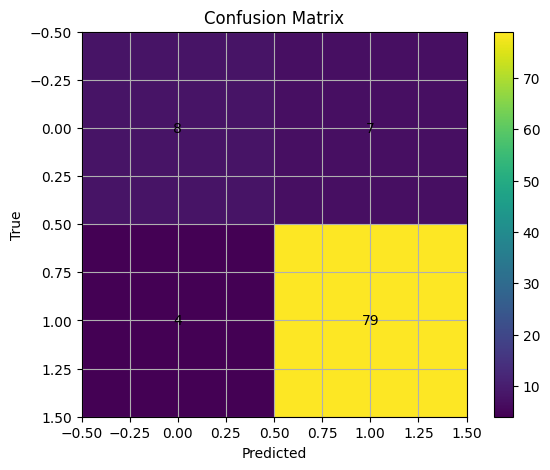

In [14]:
# 3) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap=None)
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.colorbar()
plt.show()

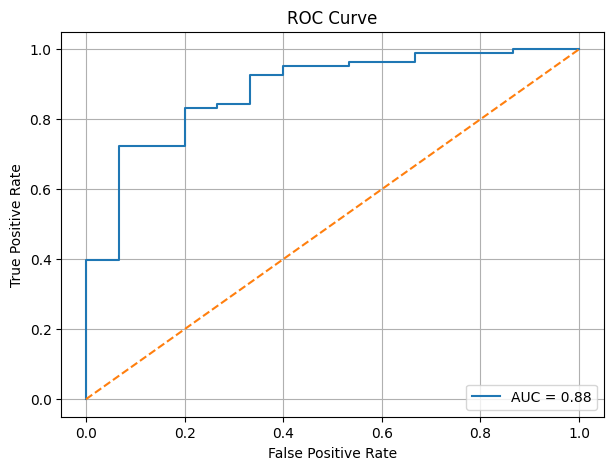

AUC: 0.8827309236947791


In [15]:
# 4) ROC Curve + AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
print('AUC:', roc_auc)